In [51]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tabulate import tabulate


from trainer import Trainer, generate_data_iter
import utils
import attack
import cam

In [52]:
model_mode, dataset, seed, cuda = 'resnet18', 'CIFAR10', 2, 0
target_layer = 'layer4' if model_mode == 'resnet18' else 'blocks'
fig_num = 100
metrics = {}

utils.set_random_seed(seed)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)

trainer.load()
scorecam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)

import os
metric_pth = f'./thesis/attack_metrics/{dataset}/'
if not os.path.exists(metric_pth):
    os.makedirs(metric_pth)
    
attack_pth = f'./thesis/attack_pics/{dataset}/'
if not os.path.exists(attack_pth):
    os.makedirs(attack_pth)

# Generate Test data
test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))
raw_cam_nps, raw_preds, _, __ = scorecam(imgs, metric = False)

# Extract Successful Results
suc_indices = raw_preds == labels
suc_imgs, suc_labels = imgs[suc_indices], labels[suc_indices]
suc_cams, suc_saliency_maps, suc_preds, suc_probs, suc_cam_metrics \
    = scorecam(suc_imgs, metric = True, saliency = True)


metrics['Raw'] = {
    'time': 0,
    'success_rate': 1,
    'delta_norm': 0,
    'Average Incr': suc_cam_metrics['Average Incr'], 
    'Average Drop': suc_cam_metrics['Average Drop'],
    'Insertion':  suc_cam_metrics['Insertion'], 
    'Deletion': suc_cam_metrics['Deletion'],
    'saliency_diff': 0,
    'shift_dist': 0
}
print(tabulate(
    list(metrics['Raw'].items()), tablefmt ='orgtbl'
))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
| time          | 0          |
| success_rate  | 1          |
| delta_norm    | 0          |
| Average Incr  | 0.378947   |
| Average Drop  | 0.00385167 |
| Insertion     | 0.714327   |
| Deletion      | 0.302743   |
| saliency_diff | 0          |
| shift_dist    | 0          |


In [53]:
def test_advatt(att, max_iter: int = None, att_kwargs: dict = {}):
    start = time.time()
    att_imgs = att(
        suc_imgs, suc_labels, max_iter = max_iter, 
        num_classes = 10, attack_kwargs = att_kwargs
    )
    finish = time.time()
    deltas = att_imgs - suc_imgs
    
    att_preds, _ = scorecam.model_predict(scorecam.tfm(att_imgs))
    
    # Success Rate
    indices = att_preds != suc_labels
    success_rate = indices.sum() / len(att_preds)

    # delta norm
    delta_norm = torch.mean(
        torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
            / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
    )
    
    # In cam part, we only focus on successful part
    att_suc_cams, att_suc_saliency, _, __, att_suc_cam_metrics \
        = scorecam(att_imgs[indices], metric = True, saliency = True)

    # delta saliency map norm
    saliency_diff = np.linalg.norm(
        att_suc_saliency - suc_saliency_maps[indices.numpy()],
        axis = (1, 2)
    ).mean()

    # maximum shift
    size = imgs.shape[-1]
    suc_max_idx_raw = np.argmax(
        suc_saliency_maps[indices.numpy()].reshape(indices.sum(), -1), axis = 1
    )
    suc_max_x, suc_max_y = suc_max_idx_raw // size, suc_max_idx_raw % size

    att_max_idx_raw = np.argmax(att_suc_saliency.reshape(len(att_suc_saliency), -1), axis = 1)
    att_max_x, att_max_y = att_max_idx_raw // size, suc_max_idx_raw % size
    shift_dist = np.sqrt((att_max_x - suc_max_x)**2 + (att_max_y - suc_max_y)**2).mean()
    
    metrics = {
        'time': finish - start,
        'success_rate': success_rate.item(),
        'delta_norm': delta_norm.item(),
        'Average Incr': att_suc_cam_metrics['Average Incr'], 
        'Average Drop': att_suc_cam_metrics['Average Drop'],
        'Insertion':  att_suc_cam_metrics['Insertion'], 
        'Deletion': att_suc_cam_metrics['Deletion'],
        'saliency_diff': saliency_diff,
        'shift_dist': shift_dist
    }
    att_name = att.__class__.__name__
    np.save(attack_pth + f'{att_name}-{dataset}-{model_mode}-seed{seed}.npy', att_imgs.numpy())
    return att_imgs, att_suc_cams, indices.numpy(), metrics

def plot_imgs(
    raw_img: torch.Tensor,
    att_img: torch.Tensor,
    suc_cam: np.ndarray,
    att_cam: np.ndarray
):
    fig = plt.figure(figsize = (12, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(np.transpose(raw_img.numpy(), (1, 2, 0)))
    plt.title('Raw')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.transpose(att_img.numpy(), (1, 2, 0)))
    plt.title('Attack')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(suc_cam)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(att_cam)
    plt.axis('off')

### FGSM

In [54]:
att = attack.FGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:00<00:00, 126.48it/s]


| time          | 0.759347  |
| success_rate  | 0.736842  |
| delta_norm    | 0.0406325 |
| Average Incr  | 0.614286  |
| Average Drop  | 0.0208034 |
| Insertion     | 0.599232  |
| Deletion      | 0.369285  |
| saliency_diff | 8.67132   |
| shift_dist    | 6.28571   |


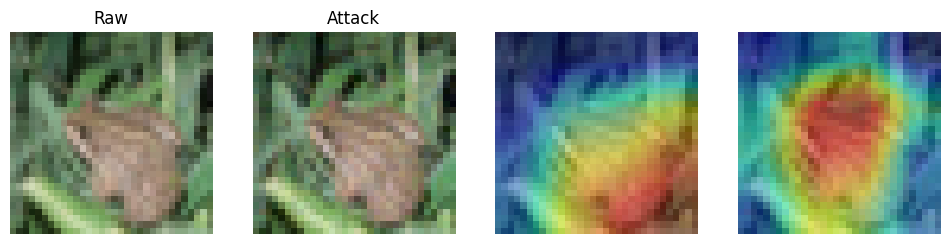

In [55]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### FGM

In [56]:
att = attack.FGM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 1}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:00<00:00, 126.09it/s]


| time          | 0.755954  |
| success_rate  | 0.757895  |
| delta_norm    | 0.0366401 |
| Average Incr  | 0.666667  |
| Average Drop  | 0.0143069 |
| Insertion     | 0.604591  |
| Deletion      | 0.380026  |
| saliency_diff | 8.81069   |
| shift_dist    | 6.08333   |


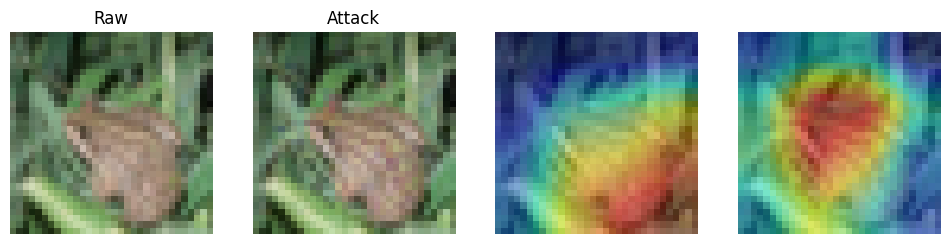

In [57]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Step-LL

In [58]:
att = attack.StepLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:01<00:00, 93.94it/s]


| time          | 1.013     |
| success_rate  | 0.568421  |
| delta_norm    | 0.0406348 |
| Average Incr  | 0.833333  |
| Average Drop  | 0.0436924 |
| Insertion     | 0.506359  |
| Deletion      | 0.181629  |
| saliency_diff | 9.97339   |
| shift_dist    | 8.05556   |


(95, 54)

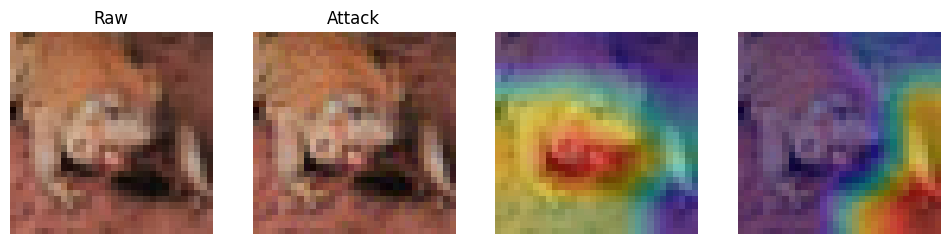

In [59]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

len(suc_imgs), len(att_suc_cams)

### I-FGSM

In [60]:
att = attack.IFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 11.98it/s]


| time          | 7.93042     |
| success_rate  | 0.989474    |
| delta_norm    | 0.0392426   |
| Average Incr  | 0.106383    |
| Average Drop  | 1.16328e-05 |
| Insertion     | 0.653865    |
| Deletion      | 0.430126    |
| saliency_diff | 7.89018     |
| shift_dist    | 5.96809     |


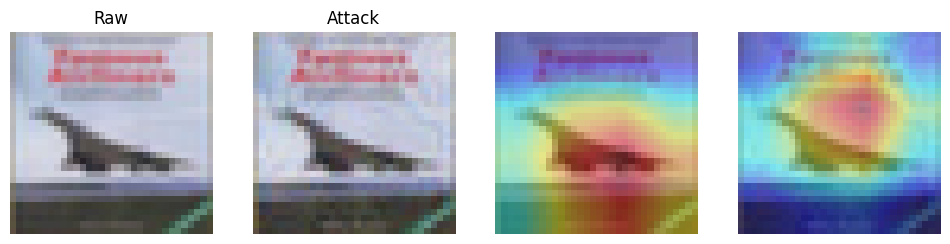

In [61]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### MI-FGSM

In [62]:
att = attack.MIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 12.43it/s]


| time          | 7.64687     |
| success_rate  | 0.989474    |
| delta_norm    | 0.0397684   |
| Average Incr  | 0.106383    |
| Average Drop  | 4.28782e-05 |
| Insertion     | 0.660214    |
| Deletion      | 0.429315    |
| saliency_diff | 8.00291     |
| shift_dist    | 5.62766     |


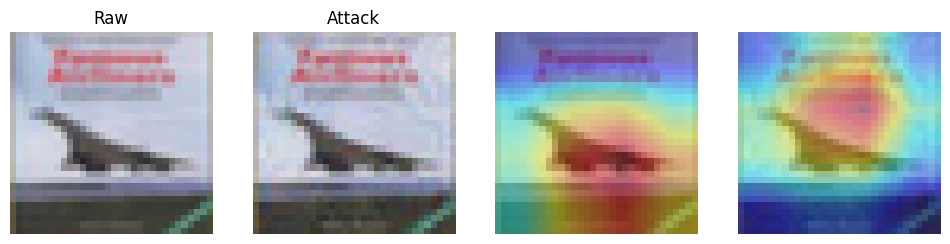

In [63]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### NIFGSM

In [64]:
att = attack.NIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.01}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 12.31it/s]


| time          | 7.72297     |
| success_rate  | 0.989474    |
| delta_norm    | 0.0397562   |
| Average Incr  | 0.106383    |
| Average Drop  | 3.27028e-05 |
| Insertion     | 0.656969    |
| Deletion      | 0.433811    |
| saliency_diff | 7.99307     |
| shift_dist    | 5.93617     |


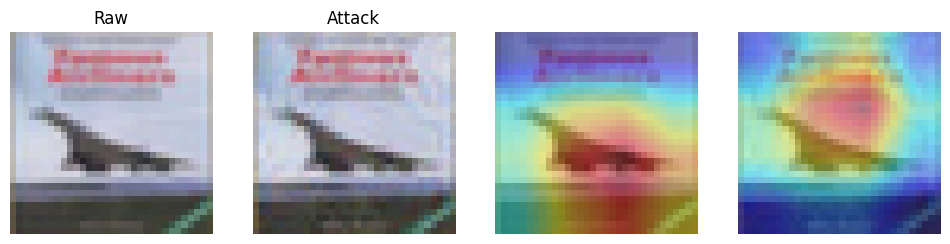

In [65]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### PGD

In [66]:
att = attack.PGD(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.02}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 12.49it/s]


| time          | 7.60482     |
| success_rate  | 0.989474    |
| delta_norm    | 0.0349239   |
| Average Incr  | 0.0851064   |
| Average Drop  | 0.000165705 |
| Insertion     | 0.656556    |
| Deletion      | 0.416328    |
| saliency_diff | 8.06849     |
| shift_dist    | 5.79787     |


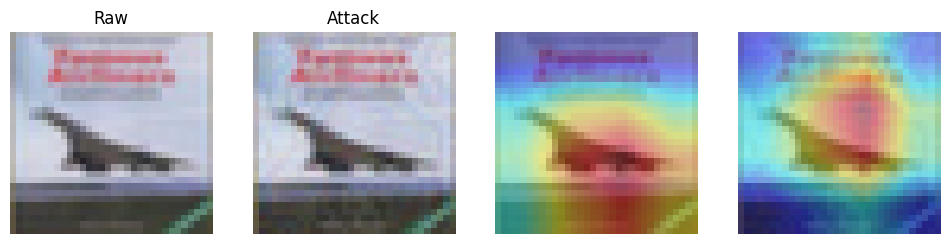

In [67]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

## IterLL

In [68]:
att = attack.IterLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.012}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:07<00:00, 11.89it/s]


| time          | 7.99293   |
| success_rate  | 0.957895  |
| delta_norm    | 0.0406986 |
| Average Incr  | 0.417582  |
| Average Drop  | 0.0151937 |
| Insertion     | 0.491618  |
| Deletion      | 0.172657  |
| saliency_diff | 8.72489   |
| shift_dist    | 6.43956   |


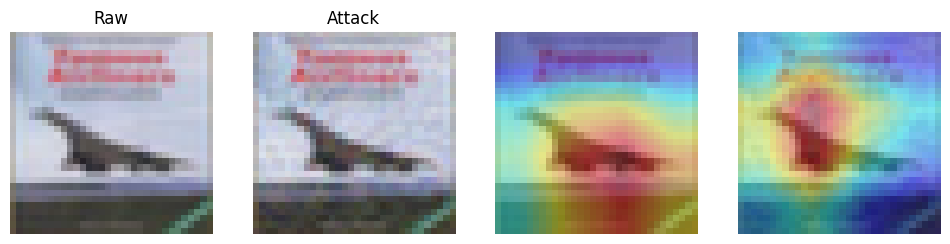

In [69]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Deep Fool

In [70]:
att = attack.DeepFool(trainer.model, cuda)
att_name = att.__class__.__name__
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [00:05<00:00, 16.21it/s]


| time          | 5.86388   |
| success_rate  | 0.873684  |
| delta_norm    | 0.291146  |
| Average Incr  | 0.746988  |
| Average Drop  | 0.0218822 |
| Insertion     | 0.565636  |
| Deletion      | 0.286433  |
| saliency_diff | 9.0751    |
| shift_dist    | 7.03614   |


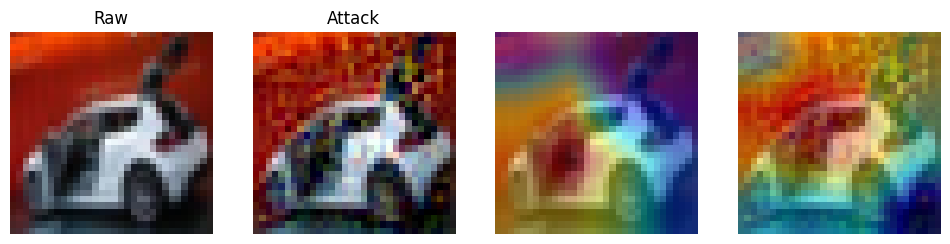

In [71]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### LBFGS

In [72]:
att = attack.LBFGS(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'c': 0.05}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 95/95 [02:26<00:00,  1.54s/it]


| time          | 146.393     |
| success_rate  |   0.505263  |
| delta_norm    |   0.0180105 |
| Average Incr  |   0.6875    |
| Average Drop  |   0.0881757 |
| Insertion     |   0.470329  |
| Deletion      |   0.137676  |
| saliency_diff |   9.74265   |
| shift_dist    |   8.25      |


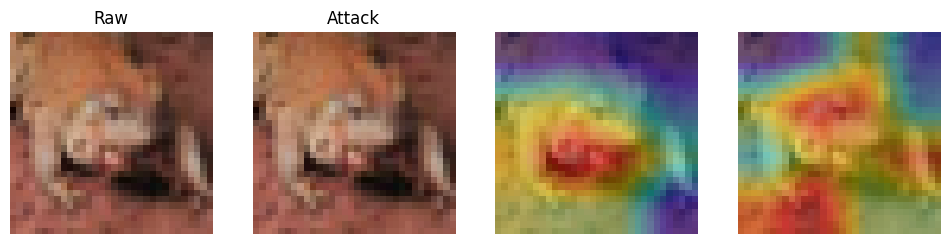

In [73]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

In [74]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(metric_pth + f'Attack-{model_mode}-{dataset}-seed{seed}.csv')
metrics_df

,Raw,FGSM,FGM,StepLL,IFGSM,MIFGSM,NIFGSM,PGD,IterLL,DeepFool,LBFGS
time,0.000000,0.759347,0.755954,1.013000,7.930421,7.646870,7.722974,7.604823,7.992926,5.863884,146.392520
success_rate,1.000000,0.736842,0.757895,0.568421,0.989474,0.989474,0.989474,0.989474,0.957895,0.873684,0.505263
delta_norm,0.000000,0.040633,0.036640,0.040635,0.039243,0.039768,0.039756,0.034924,0.040699,0.291146,0.018011
Average Incr,0.378947,0.614286,0.666667,0.833333,0.106383,0.106383,0.106383,0.085106,0.417582,0.746988,0.687500
Average Drop,0.003852,0.020803,0.014307,0.043692,0.000012,0.000043,0.000033,0.000166,0.015194,0.021882,0.088176
Insertion,0.714327,0.599232,0.604591,0.506359,0.653865,0.660214,0.656969,0.656556,0.491618,0.565636,0.470329
Deletion,0.302743,0.369285,0.380026,0.181629,0.430126,0.429315,0.433811,0.416328,0.172657,0.286433,0.137676
saliency_diff,0.000000,8.671323,8.810687,9.973390,7.890182,8.002906,7.993071,8.068490,8.724887,9.075101,9.742654
shift_dist,0.000000,6.285714,6.083333,8.055556,5.968085,5.627660,5.936170,5.797872,6.439560,7.036145,8.250000
